In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os
from opto_untils import makedirs
from plot_untils import shiftedColorMap
# load pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# load kmeans
from sklearn.cluster import KMeans
# load gmm
from sklearn.mixture import GaussianMixture
# load tsne
from sklearn.manifold import TSNE
colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)

In [3]:
def make_combine_folder(exp_name, amplitude_threshold):
    # Create a new folder to store combined files
    scratch_dir = '/root/capsule/scratch'
    combined_folder_path = os.path.join(scratch_dir, exp_name, str(amplitude_threshold))
    wf_figs_path = os.path.join(combined_folder_path, 'waveform_figs')
    print(wf_figs_path)
    wf_combined_info_path = os.path.join(combined_folder_path, 'waveform_combined_info')
    print(wf_combined_info_path)
    if not os.path.exists(combined_folder_path):
        os.makedirs(combined_folder_path)
    combined_dirs = {
        'combined_folder_raw_dir': os.path.join(scratch_dir, exp_name),
        'combined_folder_dir': combined_folder_path,
        'wf_figs_dir': wf_figs_path,
        'wf_combined_info_dir': wf_combined_info_path
    }
    makedirs(combined_dirs)
    return combined_dirs

In [4]:
amplitude_threshold = -100
combined_dirs = make_combine_folder('NPopto', amplitude_threshold=amplitude_threshold) 

# combined_all_wf_filter_1 = pd.read_pickle('/root/capsule/scratch/all_wf_NP2.0/combined_all_wf_highpass300.pkl')
# combined_all_wf_filter_2 = pd.read_pickle('/root/capsule/scratch/all_wf_NP2.0/combined_all_wf_highpass300_2.pkl')
combined_all_wf = pd.read_pickle('/root/capsule/scratch/all_wf/combined_all_wf.pkl')

/root/capsule/scratch/NPopto/-100/waveform_figs
/root/capsule/scratch/NPopto/-100/waveform_combined_info


In [5]:
# unit qc threshold
isi_threshold = 0.5
fr_range = [1, 20]
fr_baseline = [0.2]
presence_ratio = 0.9
amplitude_cutoff = 0.1
qc_op_all_wf = combined_all_wf.query(
                                        'decoder_label != "noise" &'
                                        'decoder_label != "artifact" &'
                                        'isi_violations_ratio < @isi_threshold &'
                                        'firing_rate > @fr_range[0] &'
                                        'firing_rate < @fr_range[1] &'
                                        'presence_ratio > @presence_ratio &' 
                                        'baseline_fr > @fr_baseline &'
                                        'opto_pass == True &'
                                        'amplitude <@amplitude_threshold'
                                    )
print(f"Total good opto units: {len(qc_op_all_wf)}")

qc_all_wf = combined_all_wf.query(
                                        'decoder_label != "noise" &'
                                        'decoder_label != "artifact" &'
                                        'isi_violations_ratio < @isi_threshold &'
                                        'firing_rate > @fr_range[0] &'
                                        'firing_rate < @fr_range[1] &'
                                        'presence_ratio > @presence_ratio &' 
                                        'baseline_fr > @fr_baseline &'
                                        # 'opto_pass == True'
                                        'amplitude <@amplitude_threshold'
                                    )
print(f"Total good units: {len(qc_all_wf)}")

Total good opto units: 67
Total good units: 241


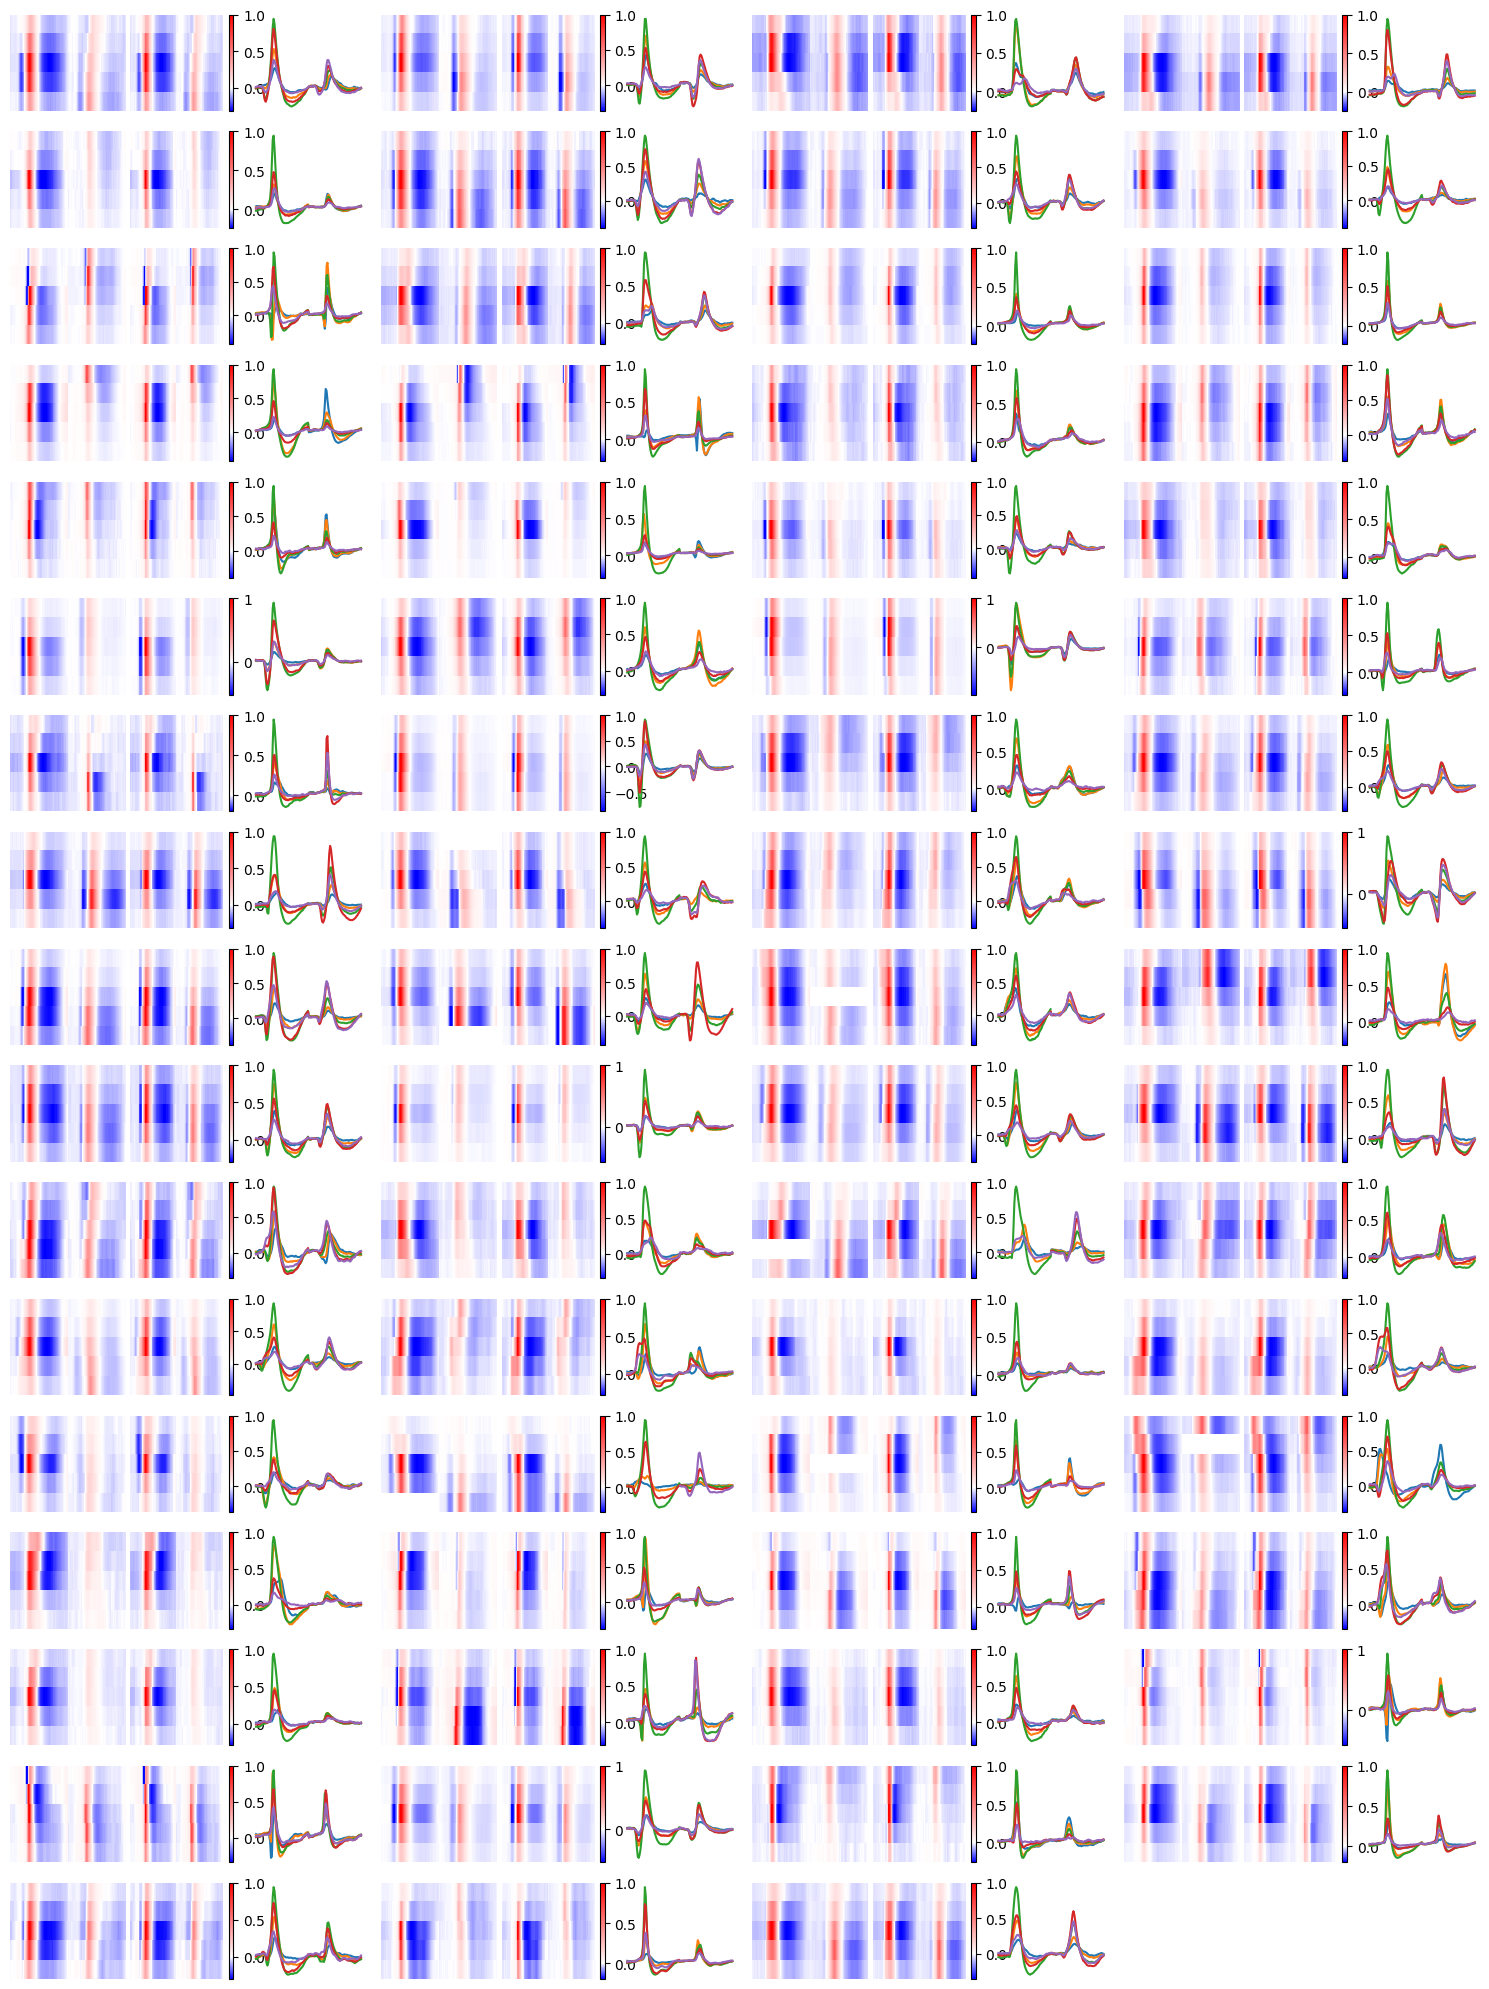

In [5]:
plt.close('all')
fig = plt.figure(figsize=(15, 20)) 
curated_all_wf = qc_op_all_wf
gs = gridspec.GridSpec(int(np.ceil(len(curated_all_wf)/int(np.round(np.sqrt(len(curated_all_wf))/2)))), int(np.round(np.sqrt(len(curated_all_wf))/2)), figure=fig)
for unit_ind in range(len(curated_all_wf) ):
    gs_sub = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[unit_ind])
    ax = fig.add_subplot(gs_sub[0])
    waveform = curated_all_wf['waveform'].values[unit_ind]
    shifted_cmap = shiftedColorMap(b_w_r_cmap, np.nanmin(waveform), np.nanmax(waveform), 'shifted_b_w_r');
    cax = ax.imshow(waveform, cmap=shifted_cmap, aspect='auto', interpolation='none');
    ax.axis('off')
    ax = fig.add_subplot(gs_sub[1])
    waveform_inter = curated_all_wf['waveform_inter'].values[unit_ind]
    ax.imshow(waveform_inter, cmap=shifted_cmap, aspect='auto', interpolation='none');
    ax.axis('off')
    fig.colorbar(cax, ax=ax)
    ax = fig.add_subplot(gs_sub[2])
    ax.plot(waveform.T);
    ax.axis('off')
    # ax = fig.add_subplot(gs[unit_ind])
    # # ax.set_title(f"Unit {curated_all_wf['ks_unit_id'].values[unit_ind]} Amplitude {curated_all_wf['amplitude'].values[unit_ind]}")

plt.tight_layout()
plt.savefig(os.path.join(combined_dirs['wf_figs_dir'], 'combined_waveforms.png'), dpi=300)
plt.show()

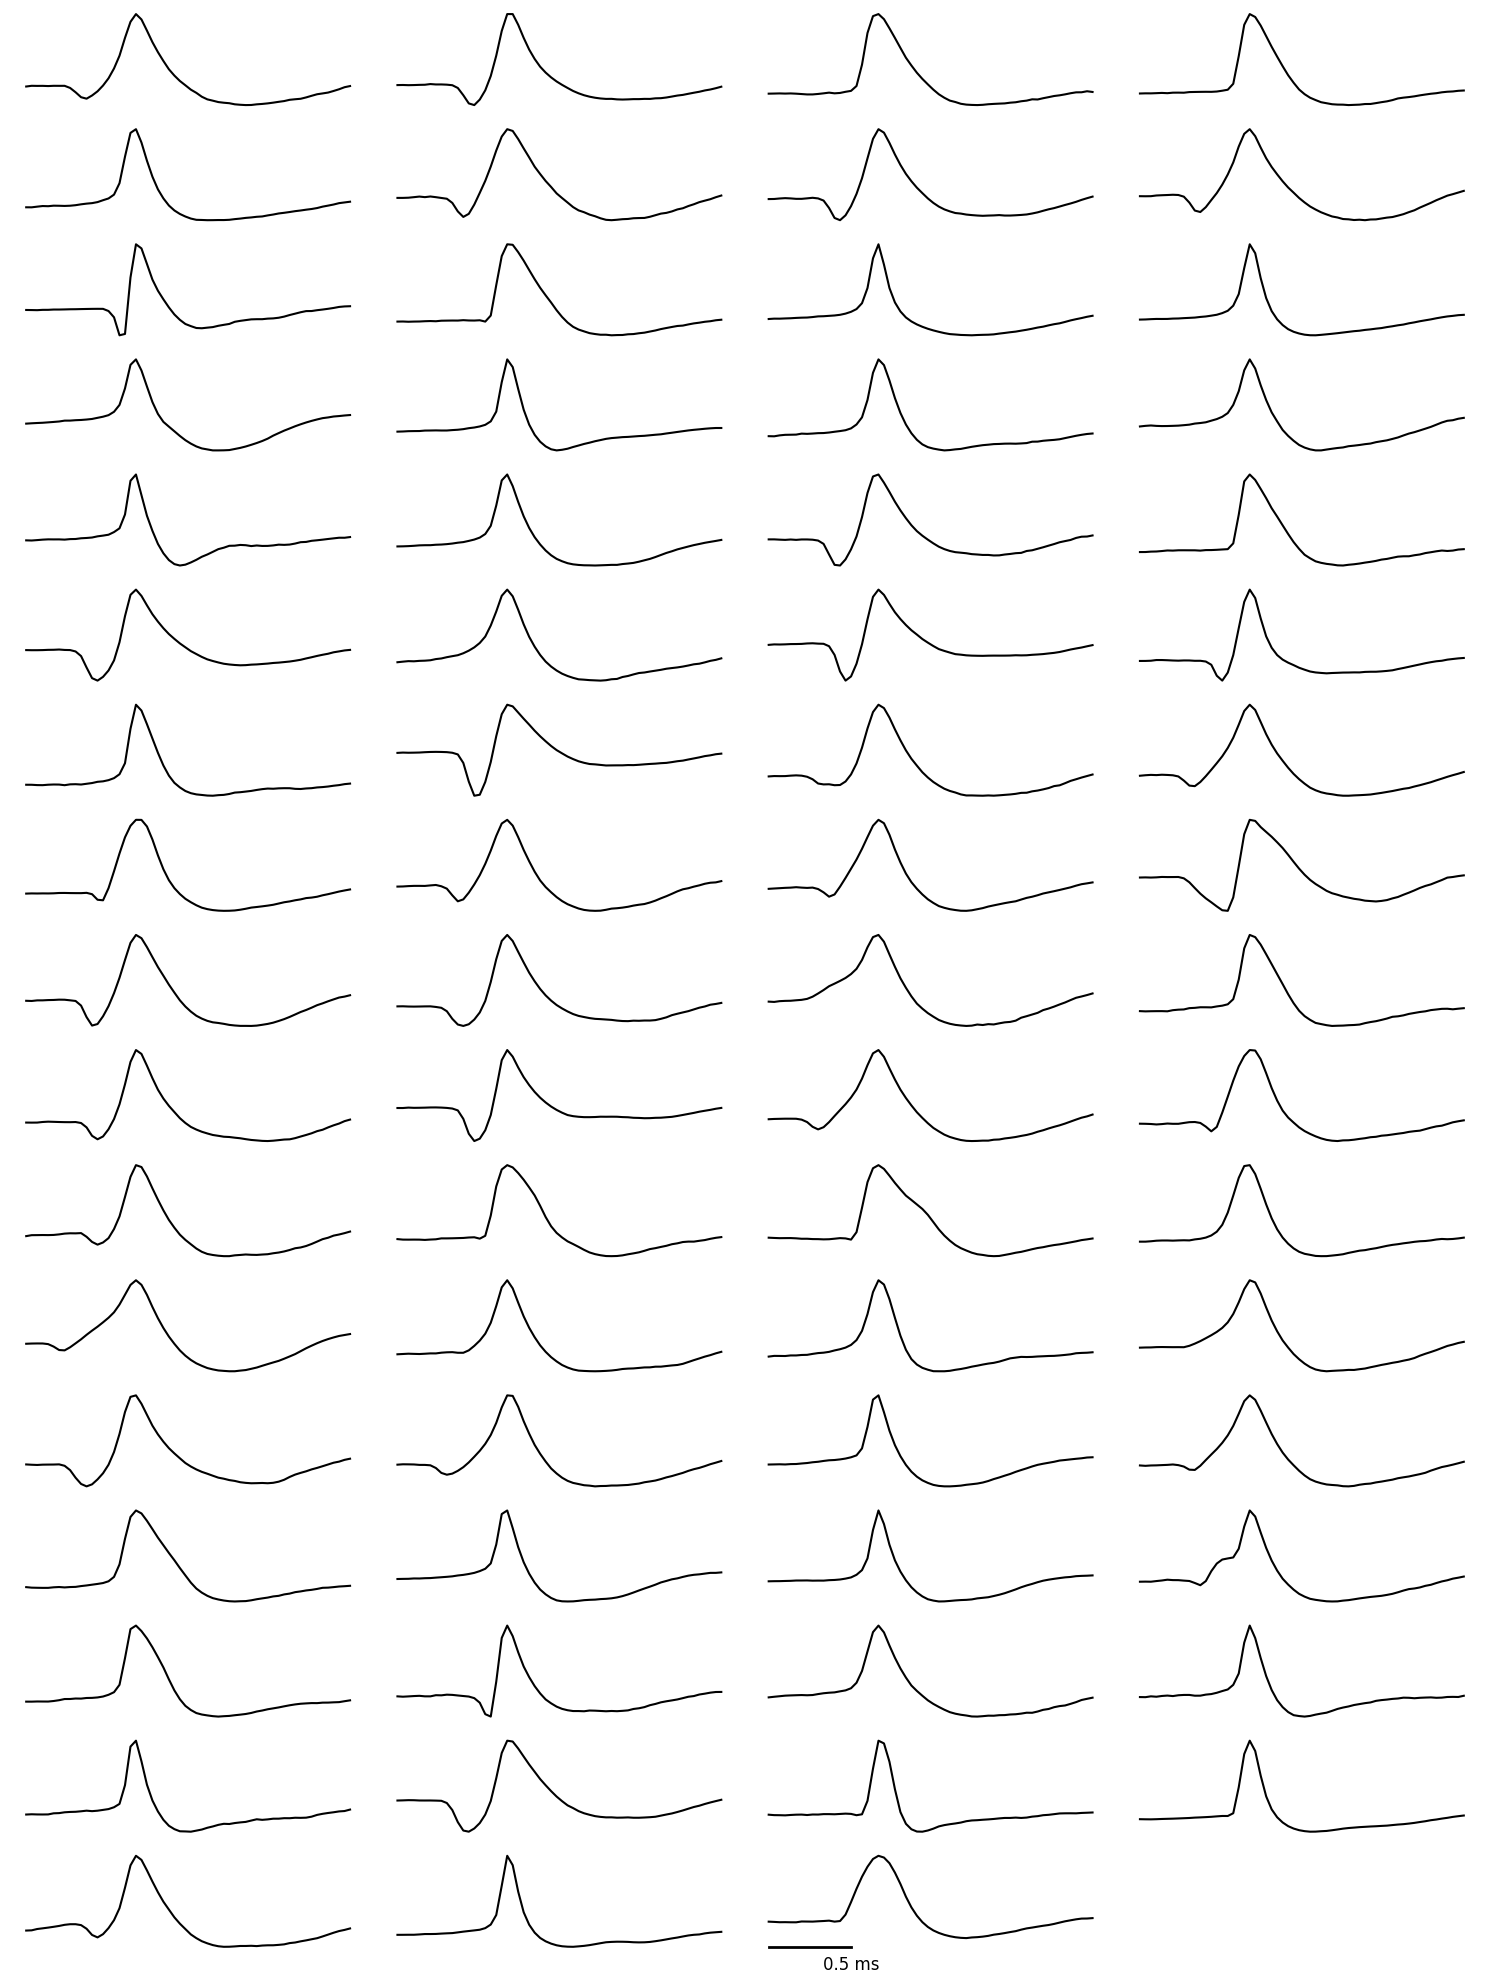

In [6]:
plt.close('all')
fig = plt.figure(figsize=(15, 20)) 
curated_all_wf = qc_op_all_wf
gs = gridspec.GridSpec(int(np.ceil(len(curated_all_wf)/int(np.round(np.sqrt(len(curated_all_wf))/2)))), int(np.round(np.sqrt(len(curated_all_wf))/2)), figure=fig)
for unit_ind in range(len(curated_all_wf)):
    ax = fig.add_subplot(gs[unit_ind])
    waveform = curated_all_wf['waveform'].values[unit_ind]
    waveform_main = waveform[np.shape(waveform)[0]//2, :np.shape(waveform)[1]//2]
    ax.plot(waveform_main, color='black');
    ax.axis('off')
    # ax = fig.add_subplot(gs[unit_ind])
    # # ax.set_title(f"Unit {curated_all_wf['ks_unit_id'].values[unit_ind]} Amplitude {curated_all_wf['amplitude'].values[unit_ind]}")
    if unit_ind==len(curated_all_wf)-1:
        ax.plot(np.array([0, 30000*0.5/1000]), np.array([-0.5, -0.5]), color='black', linewidth=2)
        ax.text(15, -0.8, '0.5 ms', fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.savefig(os.path.join(combined_dirs['wf_figs_dir'], 'combined_waveforms.pdf'), format='pdf')
plt.show()

In [7]:
# opto-tagging with location info
sessions = qc_all_wf['session_id'].unique()
# for np2.0 data
# resp_p_thresh_depth = 0.3
# resp_lat_thresh = 20/1000
# resp_win = 25/1000
# for npopto data
resp_p_thresh_depth = 0.5
resp_lat_thresh = 15/1000
resp_win = 20/1000

# initialization
all_depth_opto = pd.DataFrame()
all_depth = pd.DataFrame()
all_no_depth = pd.DataFrame()
for session in sessions:
    session_data = qc_all_wf[qc_all_wf['session_id'] == session].copy()
    # find top and bottom opto_resp
    depth_opto = session_data.query('opto_pass == True')['depth'].values
    if len(depth_opto) != 0:
        top_opto = np.max(depth_opto)
        bottom_opto = np.min(depth_opto)
        print(f"Session {session} top {top_opto} bottom {bottom_opto}")
        if top_opto > bottom_opto:
            depth_opto = (session_data['depth'].values - bottom_opto) / (top_opto - bottom_opto)
        else:
            depth_opto = (session_data['depth'].values - bottom_opto)/0.0001

    else:
        print(f"Session {session} no clear top and bottom opto")
        top_opto = np.nan
        bottom_opto = np.nan
        depth_opto = np.full(len(session_data), np.nan)

    p_resp = np.max(np.array(list(session_data['p'].values)), axis=-1) - session_data['baseline_fr'].values * resp_win
    lat_resp = np.nanmin(np.array(list(session_data['lat'].values)), axis=-1)    
    session_data = session_data.assign(max_p = p_resp)
    session_data = session_data.assign(max_lat = lat_resp)
    session_data = session_data.assign(depth_opto = depth_opto)
    session_data = session_data.assign(depth_opto_lc = session_data['depth'].values - top_opto)
    session_data = session_data.assign(depth_opto_mean = session_data['depth'] - session_data['depth'].mean())

    # create mask
    LC_mask = (session_data['depth'] >= bottom_opto) & (session_data['depth'] <= top_opto)
    opto_mask = p_resp >= resp_p_thresh_depth

    # concatenate all opto neurons
    all_depth_opto = pd.concat([all_depth_opto, session_data[opto_mask & LC_mask]])
    all_depth = pd.concat([all_depth, session_data[LC_mask]])
    all_no_depth = pd.concat([all_no_depth, session_data[~LC_mask]])
print(f"Total opto neurons: {len(all_depth_opto)}")


Session ecephys_684930_2023-09-27_10-04-04 top 888.3514418285919 bottom 187.59537813557043
Session ecephys_684930_2023-09-28_11-45-27 top 900.5805421440241 bottom 137.5901933657763
Session ecephys_684930_2023-09-28_12-44-15 top 542.7697582086788 bottom 220.33315598270886
Session ecephys_687697_2023-09-15_11-30-06 top 158.79393696911575 bottom 73.09225859670005
Session ecephys_687697_2023-09-15_12-36-06 top 453.9140349304398 bottom 36.629742802708826
Session ecephys_691893_2023-10-05_12-46-57 top 416.85085429250444 bottom 164.96041555483166
Session ecephys_691893_2023-10-06_13-48-18 top 608.6332415280528 bottom 236.08779553228493
Total opto neurons: 87


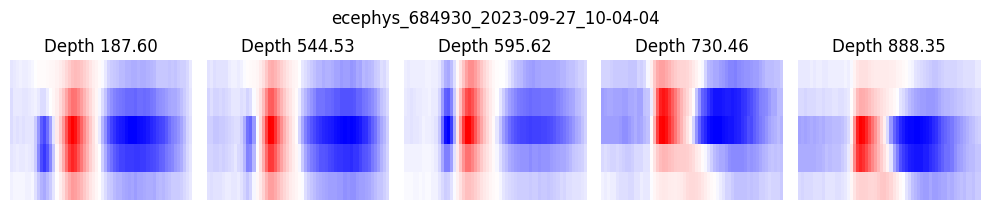

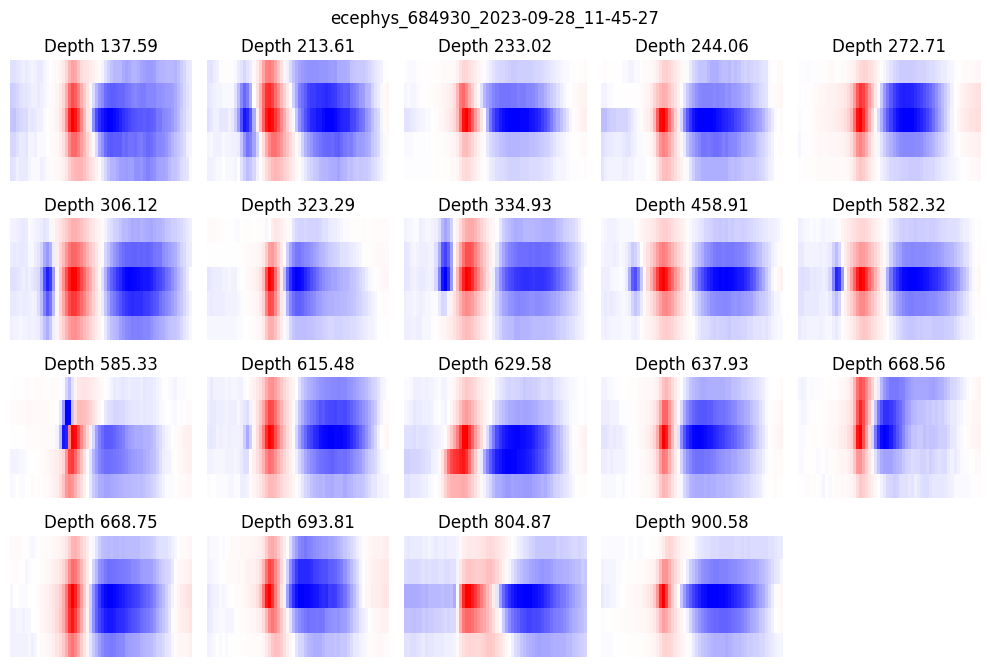

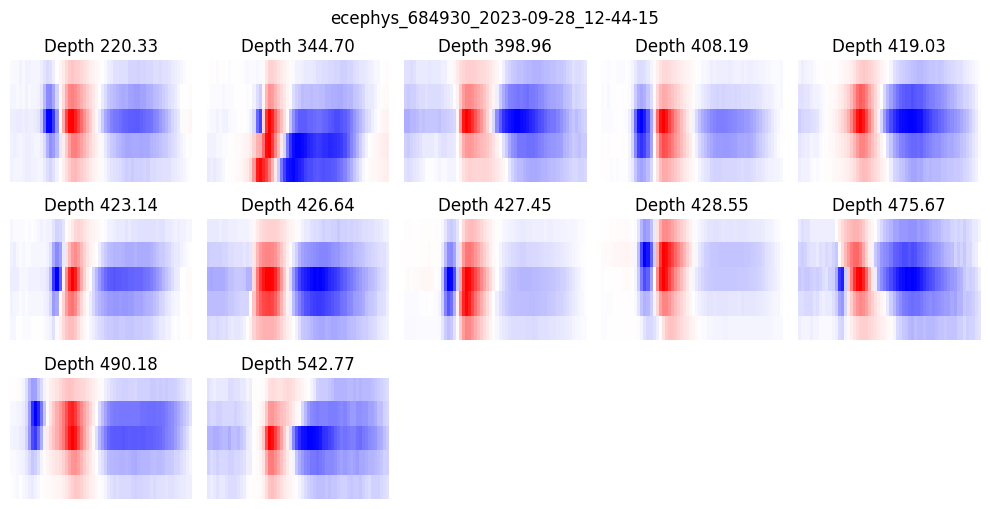

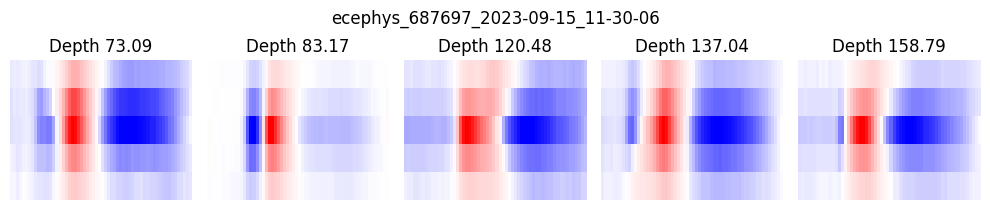

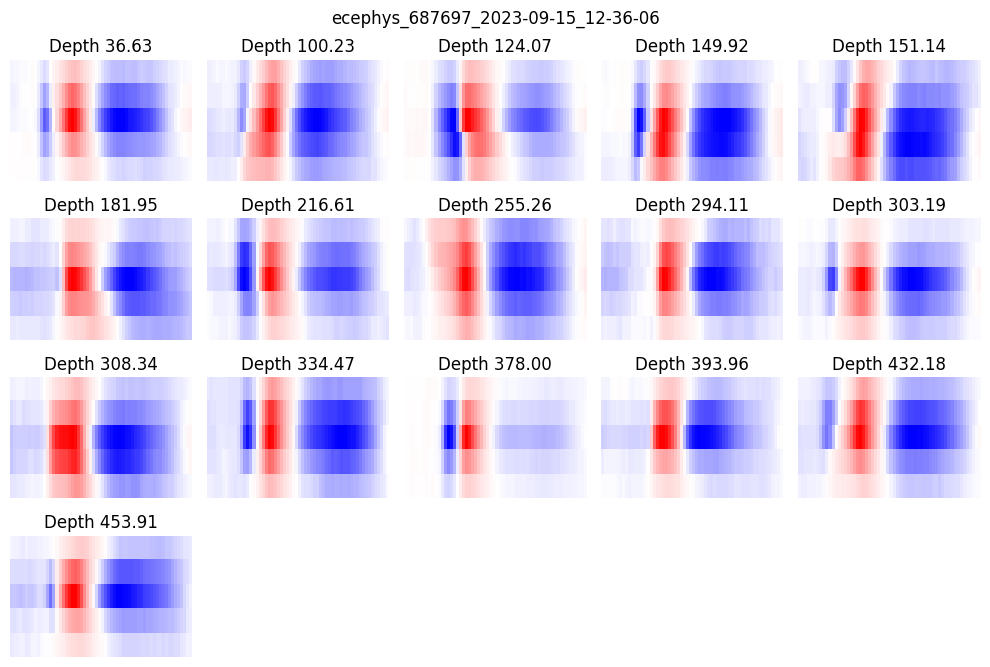

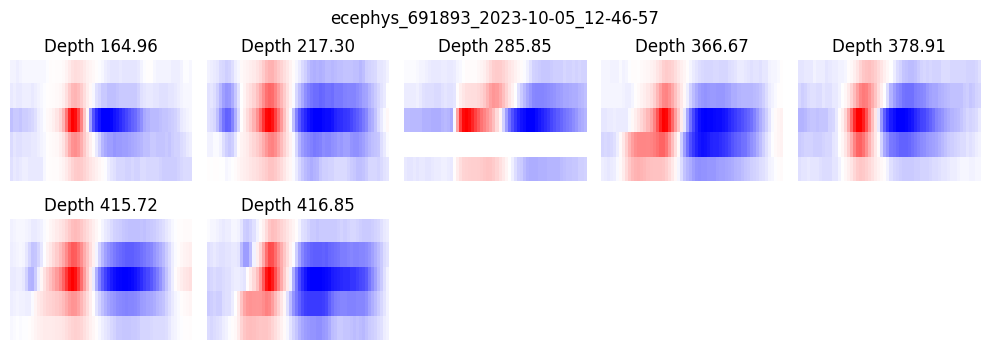

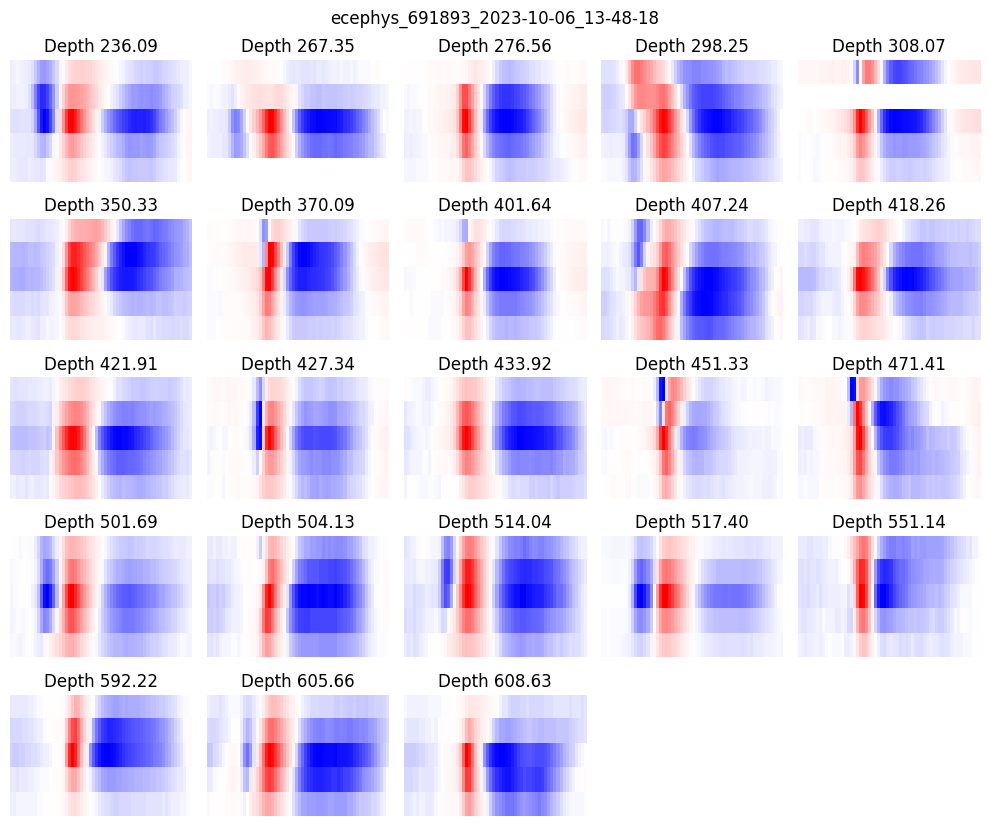

In [8]:
# opto-tagging with location info
save_path = combined_dirs['wf_figs_dir']
sessions = all_depth_opto['session_id'].unique()
colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)
for session in sessions:
    fig = plt.figure(figsize=(10, 10))
    session_data = all_depth_opto[all_depth_opto['session_id'] == session].copy()
    session_data = session_data.sort_values(by='depth')
    gs = gridspec.GridSpec(6, 5, figure=fig)
    for unit_ind in range(len(session_data)):
        ax = fig.add_subplot(gs[unit_ind // 5, unit_ind % 5])
        curr_wf = session_data['waveform'].values[unit_ind]
        curr_wf = curr_wf[:, :int(0.5*curr_wf.shape[1])]
        shifted_cmap = shiftedColorMap(b_w_r_cmap, np.nanmin(curr_wf), np.nanmax(curr_wf), 'shifted_b_w_r');
        ax.imshow(curr_wf, cmap=shifted_cmap, aspect='auto');
        ax.axis('off')
        ax.set_title(f"Depth {session_data['depth'].values[unit_ind]:.2f}")
    plt.suptitle(session)
    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(save_path, f"{session}.pdf"), format = "pdf")


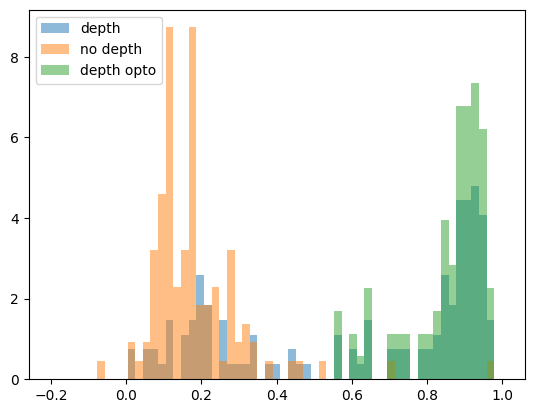

In [9]:
bins = np.linspace(-0.2, 1, 60)
plt.hist(all_depth['max_p'], bins=bins, alpha=0.5, label='depth', density=True)
plt.hist(all_no_depth['max_p'], bins=bins, alpha=0.5, label='no depth', density=True)
plt.hist(all_depth_opto['max_p'], bins=bins, alpha=0.5, label='depth opto', density=True)
plt.legend()
plt.show()

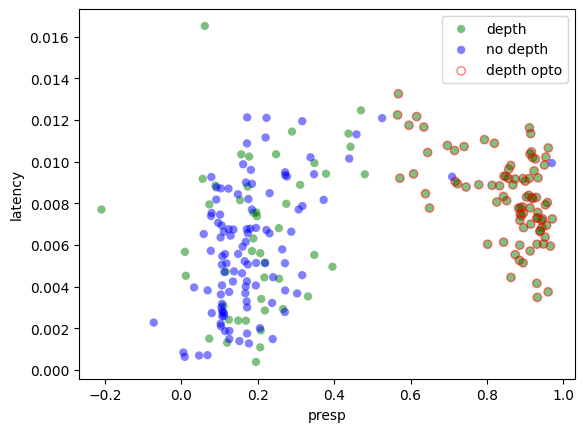

In [10]:
plt.scatter(all_depth['max_p'], all_depth['max_lat'], facecolor = 'g', label='depth', alpha=0.5, edgecolors= 'none')
plt.scatter(all_no_depth['max_p'], all_no_depth['max_lat'], facecolor = 'b', label='no depth', alpha=0.5, edgecolors= 'none')
plt.scatter(all_depth_opto['max_p'], all_depth_opto['max_lat'], facecolor = 'none', label='depth opto', alpha=0.5, edgecolors= 'r')
plt.xlabel('presp')
plt.ylabel('latency')
plt.legend()
plt.show()

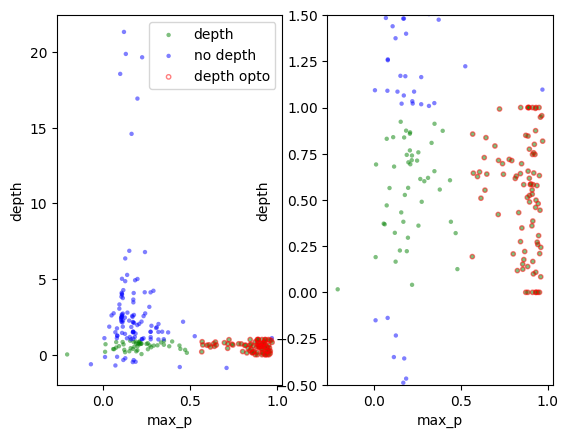

In [11]:
plt.subplot(1, 2, 1)
plt.scatter(all_depth['max_p'], all_depth['depth_opto'], facecolor = 'g', label='depth', alpha=0.5, edgecolors= 'none', s=10)
plt.scatter(all_no_depth['max_p'], all_no_depth['depth_opto'], facecolor = 'b', label='no depth', alpha=0.5, edgecolors= 'none', s=10)
plt.scatter(all_depth_opto['max_p'], all_depth_opto['depth_opto'], facecolor = 'none', label='depth opto', alpha=0.5, edgecolors= 'r', s=10)
plt.legend()
plt.xlabel('max_p')
plt.ylabel('depth')

plt.subplot(1, 2, 2)
plt.scatter(all_depth['max_p'], all_depth['depth_opto'], facecolor = 'g', label='depth', alpha=0.5, edgecolors= 'none', s=10)
plt.scatter(all_no_depth['max_p'], all_no_depth['depth_opto'], facecolor = 'b', label='no depth', alpha=0.5, edgecolors= 'none', s=10)
plt.scatter(all_depth_opto['max_p'], all_depth_opto['depth_opto'], facecolor = 'none', label='depth opto', alpha=0.5, edgecolors= 'r', s=10)
# plt.legend()
plt.xlabel('max_p')
plt.ylabel('depth')
plt.ylim(-0.5, 1.5)
plt.show()

## Sample prep

In [12]:
wf_opto_depth = np.array(list(all_depth_opto['waveform'].values))
np.shape(wf_opto_depth)
# get first half of the waveform
wf_opto_depth_major = wf_opto_depth[:, np.shape(wf_opto_depth)[1]//2, :int(np.shape(wf_opto_depth)[-1]/2)]
wf_opto_depth_major = wf_opto_depth[:, :, :int(np.shape(wf_opto_depth)[-1]/2)]
# plt.imshow(wf_opto_depth_major[0], aspect='auto')
print(np.shape(wf_opto_depth_major))
wf_opto_depth_major = np.reshape(wf_opto_depth_major, (np.shape(wf_opto_depth_major)[0], -1))
print(np.shape(wf_opto_depth_major))
# clean up nan
nan_mask = np.isnan(wf_opto_depth_major).any(axis=1)
wf_opto_depth_major_clean = wf_opto_depth_major[~nan_mask]
print(np.shape(wf_opto_depth_major_clean))

(87, 5, 60)
(87, 300)
(84, 300)


## If append samples from tagging

In [13]:
wf_opto_depth_major_clean = np.concatenate([tagged_wfs_clean, wf_opto_depth_major_clean])
np.shape(wf_opto_depth_major_clean)

NameError: name 'tagged_wfs_clean' is not defined

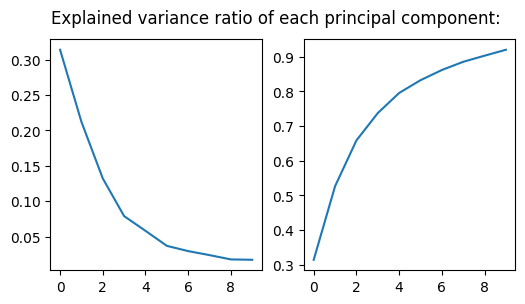

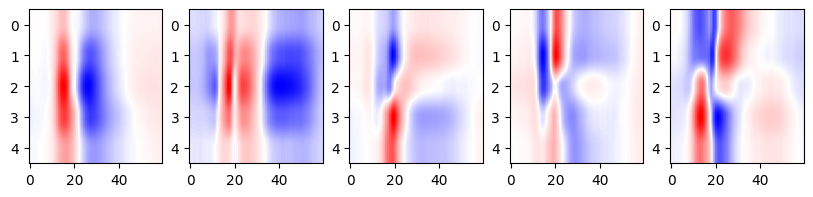

In [14]:
# Standardize the data (optional but recommended for PCA)
scaler = StandardScaler()
wf_opto_depth_major_sd = scaler.fit_transform(wf_opto_depth_major_clean)

wf_opto_depth_major_sd = wf_opto_depth_major_clean

# Apply PCA
pca = PCA(n_components=10)  # You can specify the number of components you want to keep
pca_result = pca.fit_transform(wf_opto_depth_major_sd)

# results
fig = plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_)
plt.subplot(1,2,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.suptitle("Explained variance ratio of each principal component:")
plt.show()

cmap = plt.get_cmap('bwr')
fig = plt.figure(figsize=(10, 2))
for pc_ind in range(5):
    plt.subplot(1, 5, pc_ind+1)
    pc_curr = pca.components_[pc_ind]
    pc_curr = np.reshape(pc_curr, (-1, 60))
    shifted_cmap = shiftedColorMap(cmap, np.nanmin(pc_curr), np.nanmax(pc_curr), 'shifted_b_w_r');
    plt.imshow(pc_curr, aspect='auto', cmap=shifted_cmap)

scores = pca_result[:,:5]
pc_combined = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

## Run if no tagged neurons

/tmp/ipykernel_27951/2495402695.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pc_combined['PC1'], pc_combined['amplitude'], cmap='bwr')


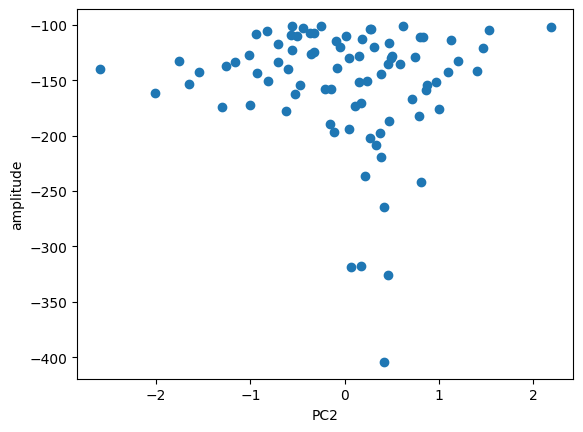

In [15]:

pc_combined['depth_opto'] = all_depth_opto.loc[~nan_mask, 'depth_opto'].values
pc_combined['amplitude'] = all_depth_opto.loc[~nan_mask, 'amplitude'].values
pc_combined['depth_opto_lc'] = all_depth_opto.loc[~nan_mask, 'depth_opto_lc'].values
pc_combined['depth_opto_mean'] = all_depth_opto.loc[~nan_mask, 'depth_opto_mean'].values
plt.scatter(pc_combined['PC1'], pc_combined['amplitude'], cmap='bwr')
plt.xlabel('PC2')
plt.ylabel('amplitude')
plt.show()

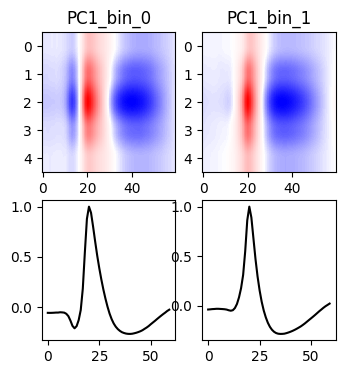

In [16]:
fig = plt.figure(figsize=(10, 4))
pc = 'PC1'
bins = np.linspace(np.min(pc_combined[pc]), np.max(pc_combined[pc]), 6)
bins = np.array([-1.5, -0.5, 1.5])

# curr_wfs = wf_opto_depth_major_clean[np.logical_and(pc_combined[pc].values>bins[bin_ind], pc_combined[pc].values<bins[bin_ind+1]), :]
# curr_wfs = np.reshape(curr_wfs, (np.shape(curr_wfs)[0], 5, 60))
# max_wf = np.max(curr_wfs)
# min_wf

# shifted_cmap = shiftedColorMap(cmap, np.nanmin(curr_wfs), np.nanmax(curr_wfs), 'shifted_b_w_r');

for bin_ind in range(len(bins)-1):
    plt.subplot(2, 5, bin_ind+1)
    curr_wfs = wf_opto_depth_major_clean[np.logical_and(pc_combined[pc].values>bins[bin_ind], pc_combined[pc].values<bins[bin_ind+1]), :]
    curr_wfs = np.reshape(curr_wfs, (np.shape(curr_wfs)[0], -1, 60))
    curr_wfs = np.mean(curr_wfs, axis=0)
    shifted_cmap = shiftedColorMap(cmap, np.nanmin(curr_wfs), np.nanmax(curr_wfs), 'shifted_b_w_r');
    plt.imshow(curr_wfs, aspect='auto', cmap=shifted_cmap)
    plt.title(f"{pc}_bin_{bin_ind}")

    plt.subplot(2, 5, bin_ind+6)
    plt.plot(curr_wfs[curr_wfs.shape[0]//2, :], color='black')

plt.savefig(os.path.join(save_path, f"PC2_waveforms.pdf"), format='pdf')

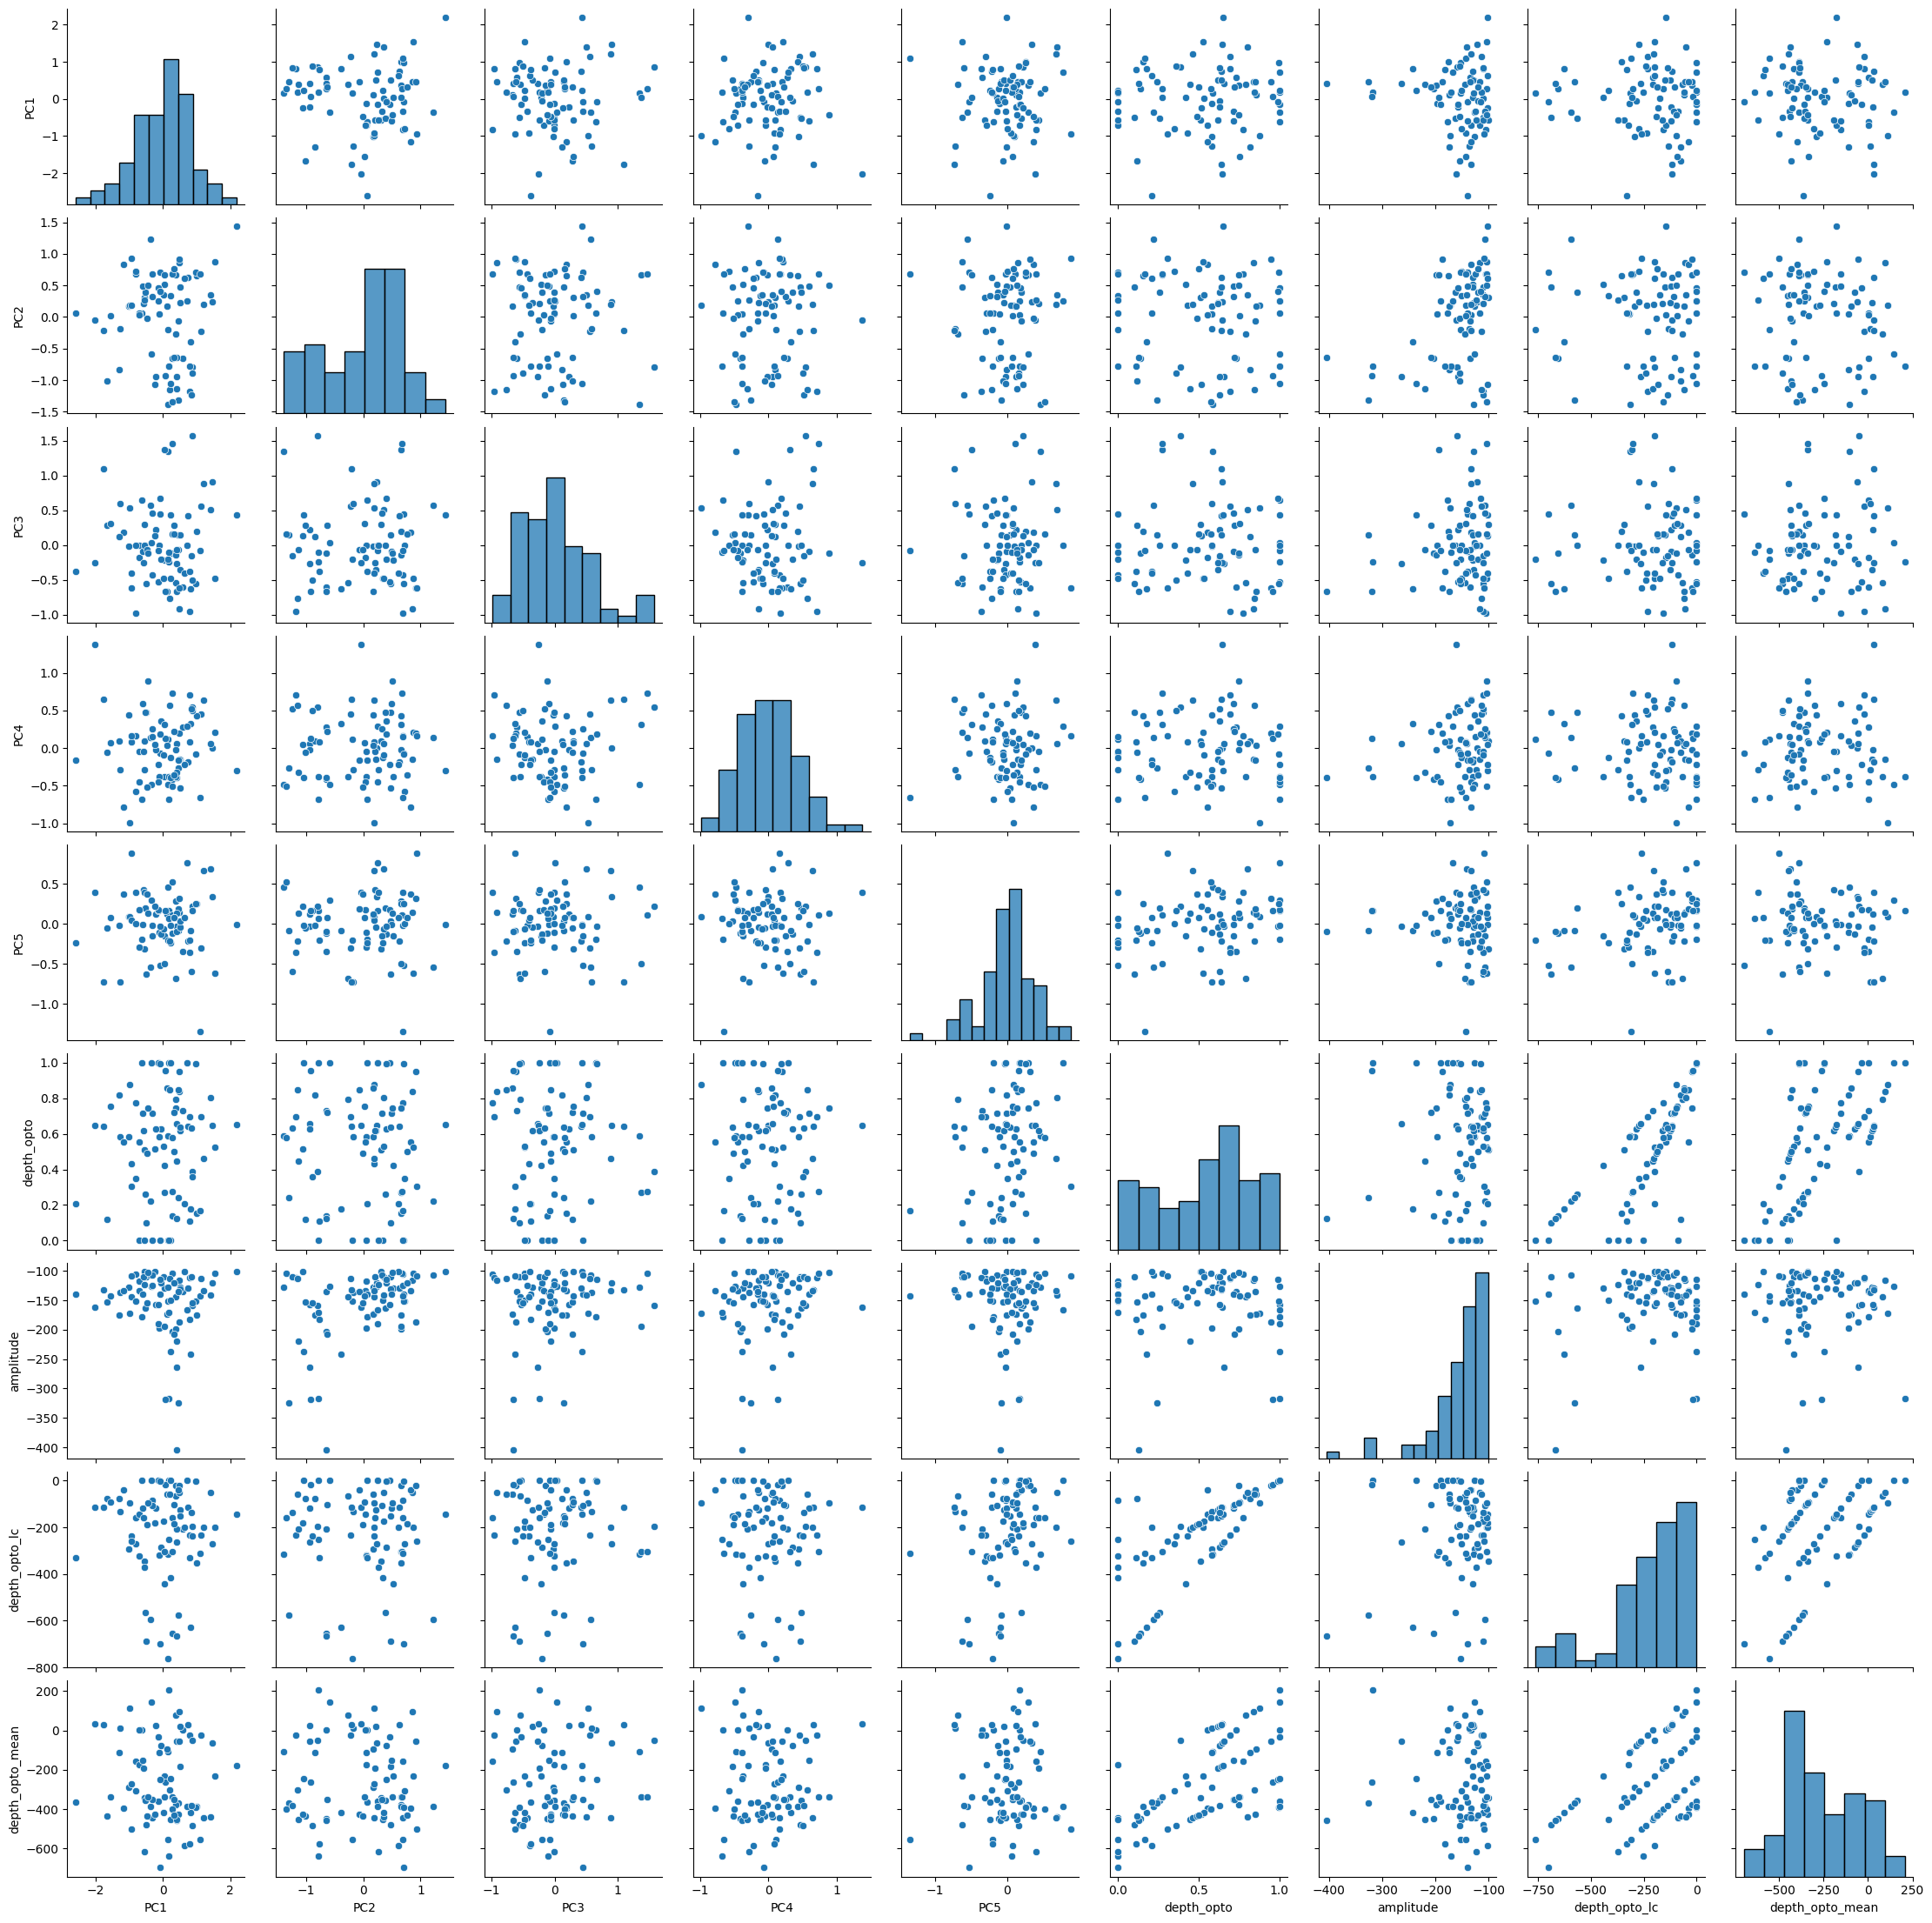

In [17]:
sns.pairplot(pc_combined)

Means of the Gaussians:
[[ 0.39167436 -0.89052763]
 [-0.15516799  0.35279659]]

Covariances of the Gaussians:
[[[0.12162743 0.02079844]
  [0.02079844 0.095037  ]]

 [[0.84642798 0.18468448]
  [0.18468448 0.1853688 ]]]


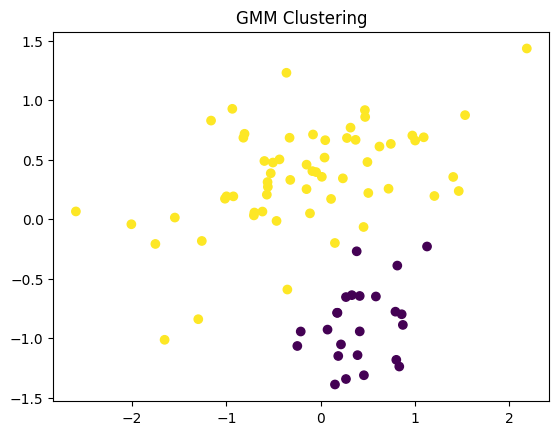

In [18]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Step 1: Generate some sample data (for demonstration)
X = pc_combined[['PC1', 'PC2']].values
# Step 2: Fit the Gaussian Mixture Model (GMM)
group_num = 2
gmm = GaussianMixture(n_components=group_num, random_state=40)  # 2 Gaussian components
gmm.fit(X)

# Step 3: Get results
labels = gmm.predict(X)  # Predicted labels for each point
probabilities = gmm.predict_proba(X)  # Probabilities of each point belonging to each Gaussian component

# Print the means and covariances of the Gaussians
print("Means of the Gaussians:")
print(gmm.means_)
print("\nCovariances of the Gaussians:")
print(gmm.covariances_)

# Step 4: Visualize the results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title("GMM Clustering")
plt.show()


Means of the Gaussians:
[[ 0.39167436 -0.89052763]
 [-0.15516799  0.35279659]]

Covariances of the Gaussians:
[[[0.12162743 0.02079844]
  [0.02079844 0.095037  ]]

 [[0.84642798 0.18468448]
  [0.18468448 0.1853688 ]]]


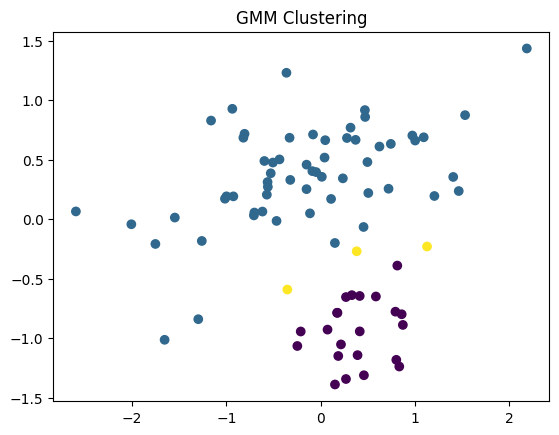

In [19]:
# Step 3: Get results
labels = gmm.predict(X)  # Predicted labels for each point
probabilities = gmm.predict_proba(X)  # Probabilities of each point belonging to each Gaussian component
labels[np.max(probabilities, axis=1)<0.7] = group_num+1
# Print the means and covariances of the Gaussians
print("Means of the Gaussians:")
print(gmm.means_)
print("\nCovariances of the Gaussians:")
print(gmm.covariances_)

# Step 4: Visualize the results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title("GMM Clustering")
plt.show()

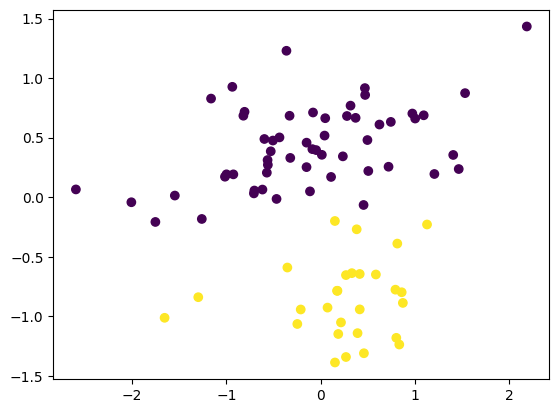

In [20]:
# kmeans

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=group_num, random_state=24)
kmeans.fit(X)
labels = kmeans.predict(X)
centers = kmeans.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')

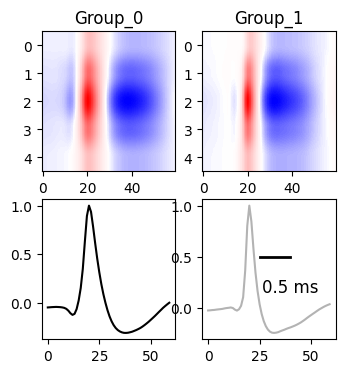

In [21]:
fig = plt.figure(figsize=(10, 4))
colors = [np.array([0, 0, 0, 1]), np.array([0.7, 0.7, 0.7, 1])]
for bin_ind in range(group_num):
    plt.subplot(2, 5, bin_ind+1)
    curr_wfs = wf_opto_depth_major_clean[labels==bin_ind, :]
    curr_wfs = np.reshape(curr_wfs, (np.shape(curr_wfs)[0], -1, 60))
    curr_wfs = np.mean(curr_wfs, axis=0)
    shifted_cmap = shiftedColorMap(cmap, np.nanmin(curr_wfs), np.nanmax(curr_wfs), 'shifted_b_w_r');
    plt.imshow(curr_wfs, aspect='auto', cmap=shifted_cmap)
    plt.title(f"Group_{bin_ind}")

    plt.subplot(2, 5, bin_ind+6)
    plt.plot(curr_wfs[curr_wfs.shape[0]//2, :], color=colors[bin_ind])
    if bin_ind==group_num-1:
        plt.plot(25+np.array([0, 30000*0.5/1000]), np.array([0.5, 0.5]), color='black', linewidth=2)
        plt.text(40, 0.2, '0.5 ms', fontsize=12, ha='center', va='center')

plt.savefig(os.path.join(save_path, f"group_waveforms.pdf"), format='pdf')


0
1
2
3
4
5
7
8
9
11
12
13
15
24
26
27
28
29
32
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
50
52
53
54
55
56
57
58
59
60
62
63
65
66
69
70
72
75
77
80
82
83


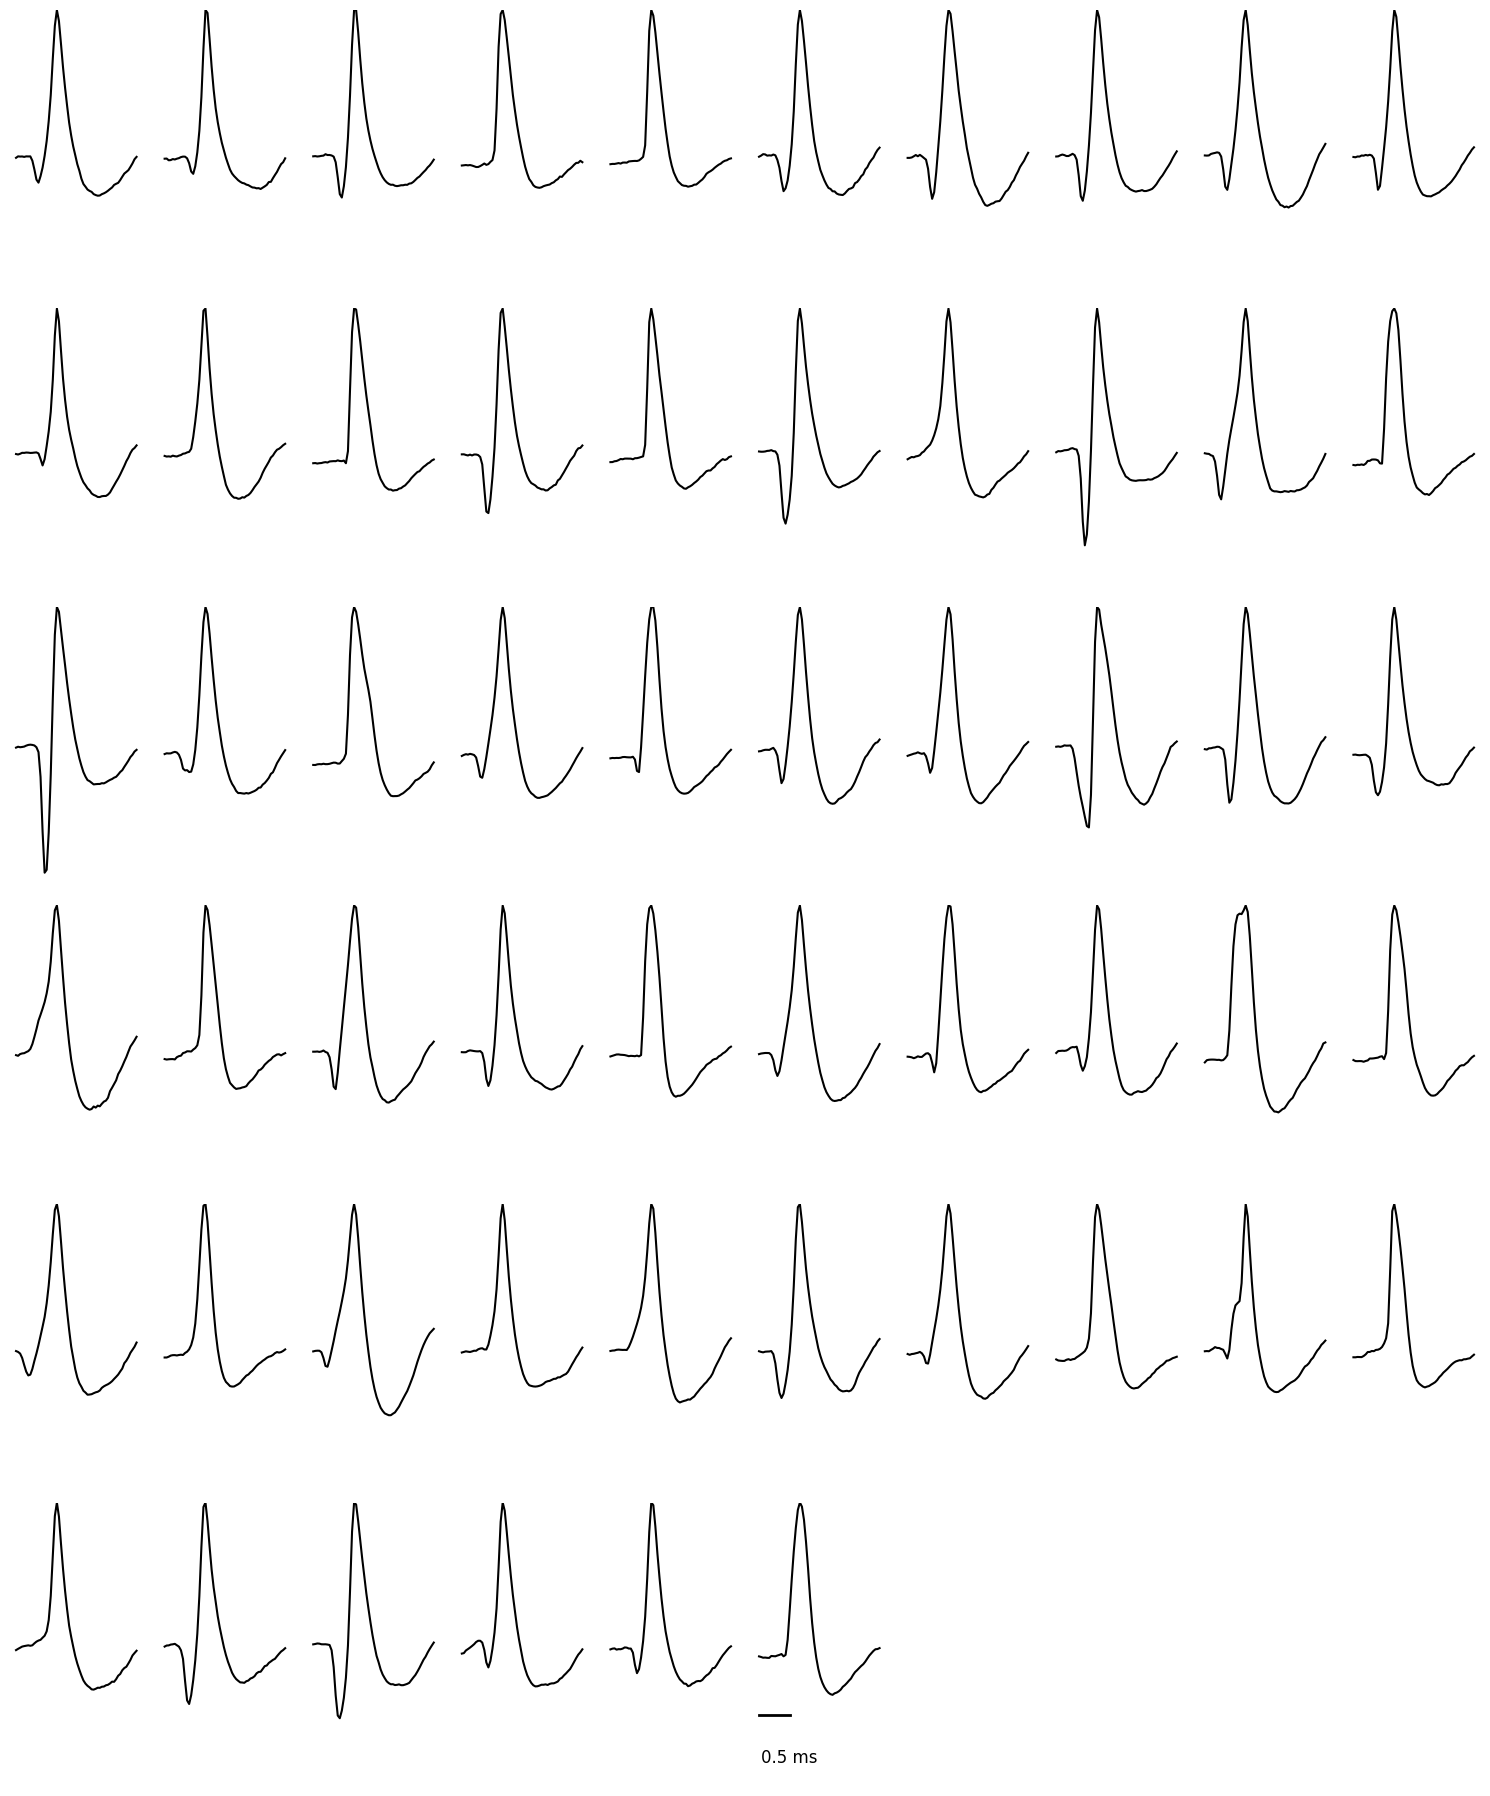

6
10
14
16
17
18
19
20
21
22
23
25
30
31
33
37
51
61
64
67
68
71
73
74
76
78
79
81


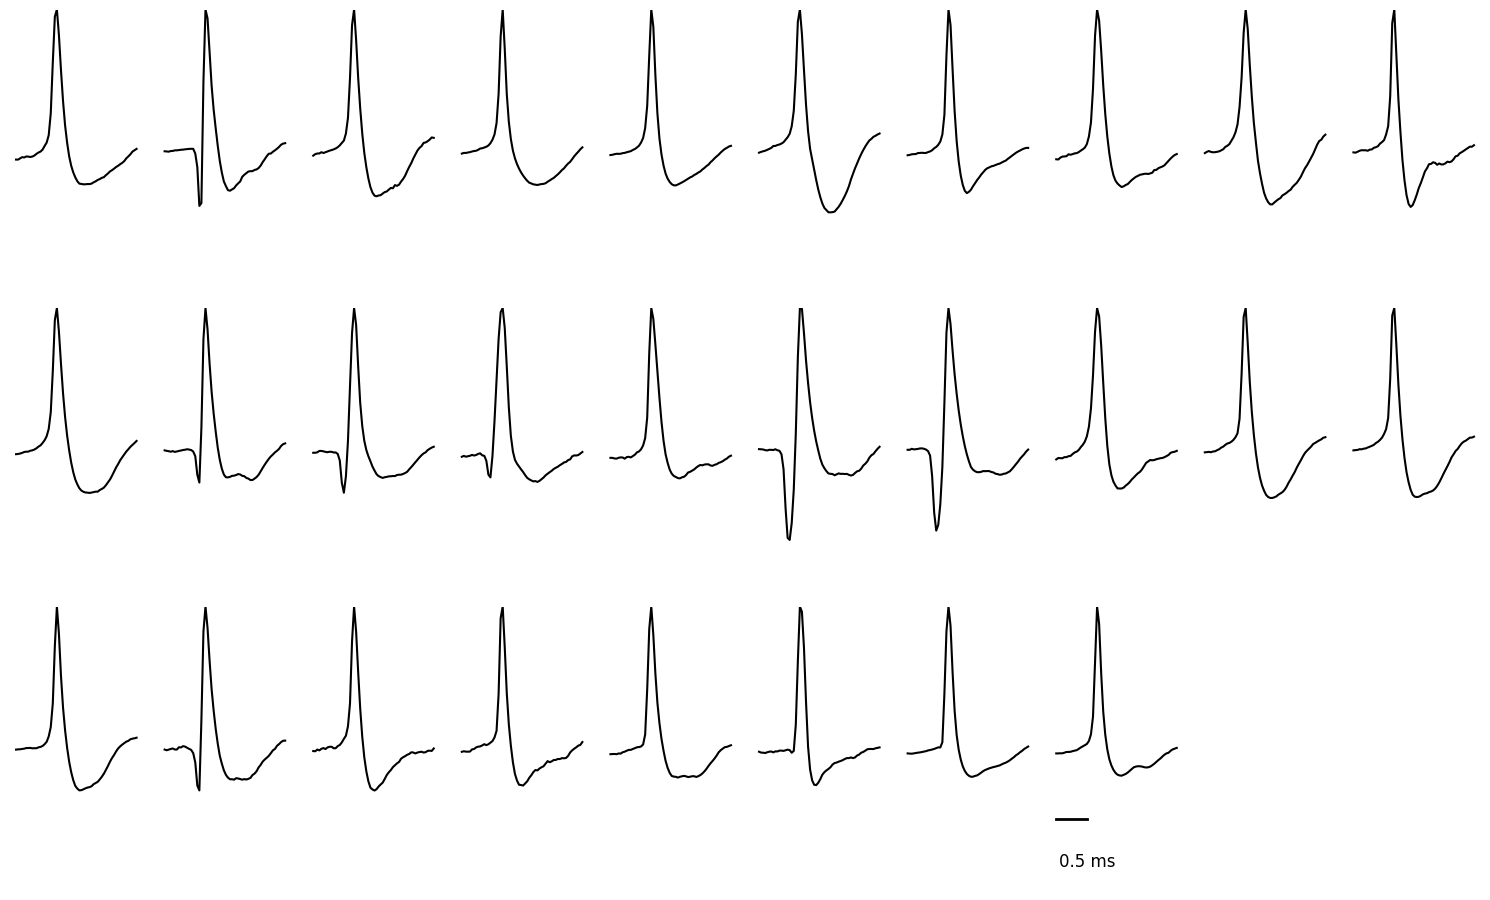

In [24]:
plt.close('all')
wf_opto_depth_major_clean_reshape = np.reshape(wf_opto_depth_major_clean, (np.shape(wf_opto_depth_major_clean)[0], -1, 60))
for group_ind in range(group_num):
    fig = plt.figure(figsize=(15, 30)) 
    gs = gridspec.GridSpec(10, 10, figure=fig)
    curr_unit_inds = np.where(labels==group_ind)[0]
    for unit_count, unit_ind in enumerate(list(curr_unit_inds)):
        print(unit_ind)
        ax = fig.add_subplot(gs[unit_count])
        waveform = wf_opto_depth_major_clean_reshape[unit_ind,:,:]
        waveform_main = waveform[np.shape(waveform)[0]//2, :]
        ax.plot(waveform_main, color='black');
        ax.set_ylim(-1, 1)
        ax.axis('off')
        # ax = fig.add_subplot(gs[unit_ind])
        # ax.set_title(f"Unit {curated_all_wf['ks_unit_id'].values[unit_ind]} Amplitude {curated_all_wf['amplitude'].values[unit_ind]}")
        if unit_count==len(curr_unit_inds)-1:
            ax.plot(np.array([0, 30000*0.5/1000]), np.array([-0.5, -0.5]), color='black', linewidth=2)
            ax.text(15, -0.8, '0.5 ms', fontsize=12, ha='center', va='center')

    plt.tight_layout()
    plt.savefig(os.path.join(combined_dirs['wf_figs_dir'], f'combined_waveforms_group{group_ind}.pdf'), format='pdf')
    plt.show()

In [25]:
save_path

'/root/capsule/scratch/NPopto/-100/waveform_figs'

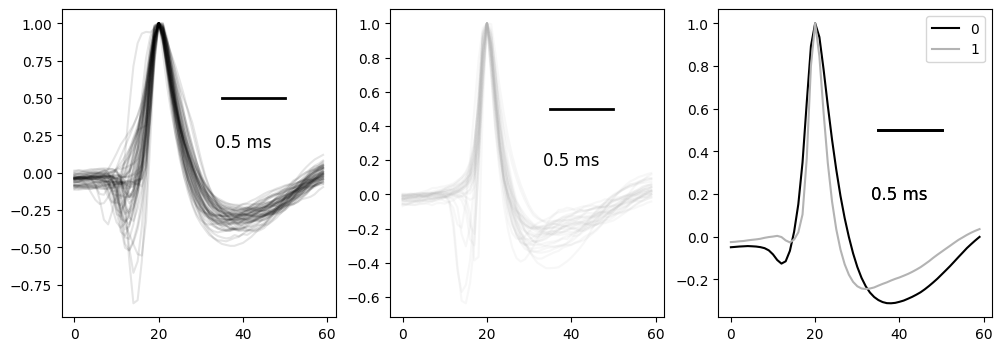

In [53]:
save_path = combined_dirs['wf_figs_dir']
fig = plt.figure(figsize=(12, 4))
for bin_ind in range(group_num):
    plt.subplot(1, group_num+1, bin_ind+1)
    curr_wfs = wf_opto_depth_major_clean[labels==bin_ind, :]
    curr_wfs = np.reshape(curr_wfs, (np.shape(curr_wfs)[0], -1, 60))
    plt.plot(curr_wfs[:, curr_wfs.shape[1]//2, :].T, color=colors[bin_ind], alpha=0.1)
    plt.plot(35+np.array([0, 30000*0.5/1000]), np.array([0.5, 0.5]), color='black', linewidth=2)
    plt.text(40, 0.2, '0.5 ms', fontsize=12, ha='center', va='center')

for bin_ind in range(group_num):
    plt.subplot(1, group_num+1, group_num+1)
    curr_wfs = wf_opto_depth_major_clean[labels==bin_ind, :]
    curr_wfs = np.reshape(curr_wfs, (np.shape(curr_wfs)[0], -1, 60))
    plt.plot(np.mean(np.squeeze(curr_wfs[:, curr_wfs.shape[1]//2, :]), axis = 0), color=colors[bin_ind], label = bin_ind)
    plt.plot(35+np.array([0, 30000*0.5/1000]), np.array([0.5, 0.5]), color='black', linewidth=2)
    plt.text(40, 0.2, '0.5 ms', fontsize=12, ha='center', va='center')
    plt.legend()

plt.savefig(os.path.join(save_path, f"mean_group_waveforms.pdf"), format='pdf')


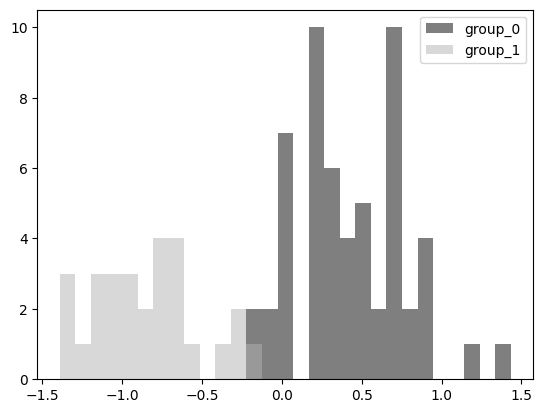

In [55]:
pc_focus = 'PC2'
bins = np.linspace(np.min(pc_combined[pc_focus]), np.max(pc_combined[pc_focus]), 30)
for group in range(group_num):
    plt.hist(pc_combined.loc[labels==group, pc_focus], bins = bins, label=f'group_{group}', density=False, alpha=0.5, color=colors[group])
plt.legend()
plt.savefig(os.path.join(save_path, f"{pc_focus}_hist.pdf"), format='pdf')

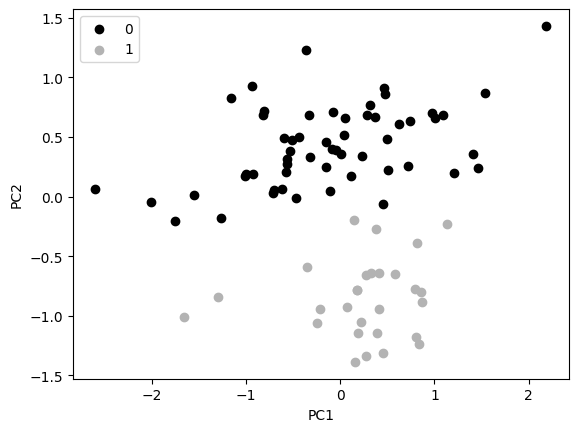

In [56]:
# Step 3: Get results

# labels[np.max(probabilities, axis=1)<0.7] = group_num+1
# Print the means and covariances of the Gaussians
for group_ind in range(group_num):
    plt.scatter(pc_combined['PC1'].values[labels==group_ind], pc_combined['PC2'].values[labels==group_ind], color = colors[group_ind], label = group_ind)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

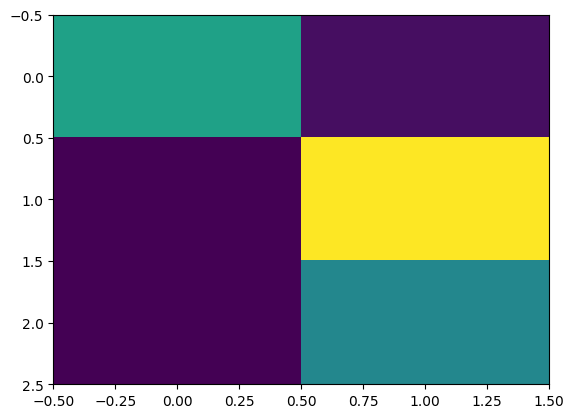

In [142]:
groups_1D = np.unique(label_1D[~nan_mask])
groups_2D = np.unique(label_2D)
match_mat = np.zeros(shape=(len(groups_1D), len(groups_2D)))
for group_ind_1D, group_1D in enumerate(groups_1D):
    for group_ind_2D, group_2D in enumerate(groups_2D):
        match_mat[group_ind_1D, group_ind_2D] = np.sum((label_1D[~nan_mask] == group_1D) & (label_2D == group_2D))
plt.imshow(match_mat, aspect='auto')

In [26]:
# load tagged units
tagged_units = pd.read_pickle(os.path.join(save_path, 'tagged_wf.pkl'))

In [49]:
tagged_wfs = np.array(list(tagged_units['waveform'].values))
tagged_wfs = tagged_wfs[:, :, :int(tagged_wfs.shape[-1]/2)]
tagged_wfs = np.reshape(tagged_wfs, (tagged_wfs.shape[0], -1))
nan_ind_tag = np.isnan(tagged_wfs).any(axis=1)
tagged_wfs_clean = tagged_wfs[np.logical_and(~nan_ind_tag, tagged_units['amplitude']<-80), :]
tagged_ind = np.array(range(len(tagged_wfs_clean)))

## Go back from here to redo clustering

In [145]:
tag_mask = np.zeros(len(wf_opto_depth_major_clean), dtype=bool)
tag_mask[tagged_ind] = True
wf_opto_depth_major_clean_2D = np.reshape(wf_opto_depth_major_clean, (np.shape(wf_opto_depth_major_clean)[0], -1, 60))
ahp = np.array(np.min(wf_opto_depth_major_clean_2D[:, np.shape(wf_opto_depth_major_clean_2D)[1]//2, :], axis=1))
pc_combined['ahp'] = ahp
pc_combined['pl_tag'] = tag_mask

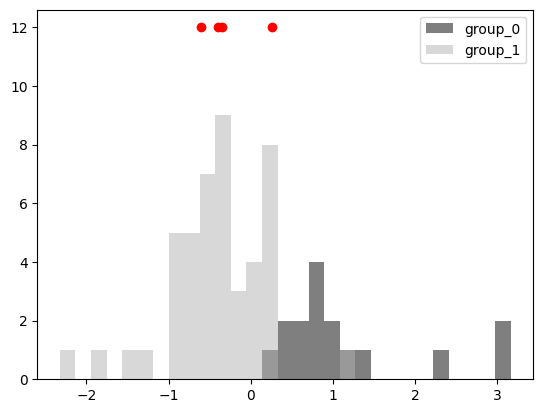

In [146]:
focus = 'PC1'
bins = np.linspace(np.min(pc_combined[focus]), np.max(pc_combined[focus]), 30)
for group in range(group_num):
    plt.hist(pc_combined.loc[labels==group, focus], bins = bins, label=f'group_{group}', density=False, alpha=0.5, color=colors[group])
plt.scatter(pc_combined.loc[tagged_ind, focus], 12*np.ones_like(pc_combined.loc[tagged_ind, focus]), color = 'red')
plt.legend()
plt.savefig(os.path.join(save_path, f"PC1_scatter.pdf"), format='pdf')

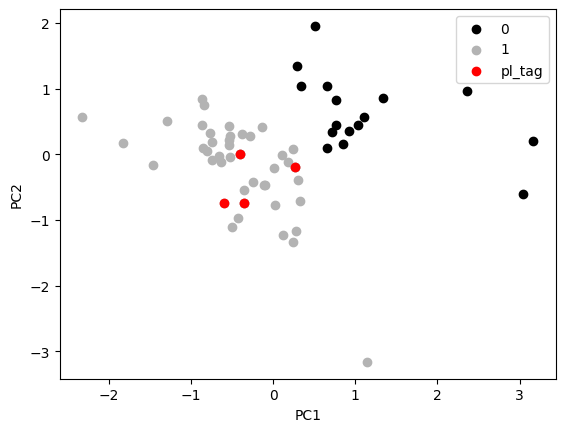

In [147]:
# Step 3: Get results

labels[np.max(probabilities, axis=1)<0.7] = group_num+1
# Print the means and covariances of the Gaussians
for group_ind in range(group_num):
    plt.scatter(pc_combined['PC1'].values[labels==group_ind], pc_combined['PC2'].values[labels==group_ind], color = colors[group_ind], label = group_ind)

plt.scatter(pc_combined['PC1'].values[tagged_ind], pc_combined['PC2'].values[tagged_ind], color = 'red', label = 'pl_tag')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.show()

plt.savefig(os.path.join(save_path, f"PC1_PC2_scatter.pdf"), format='pdf')



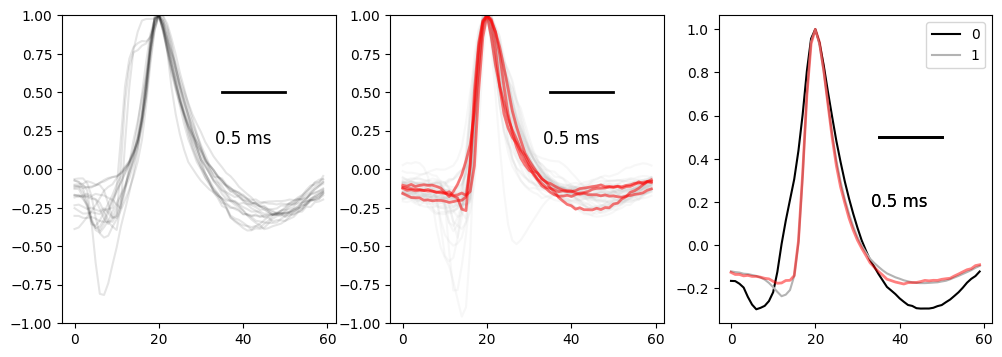

In [121]:
save_path = '/root/capsule/scratch/all_wf/amp_100'
fig = plt.figure(figsize=(12, 4))
for bin_ind in range(group_num):
    plt.subplot(1, group_num+1, bin_ind+1)
    curr_wfs = wf_opto_depth_major_clean[labels==bin_ind, :]
    curr_wfs = np.reshape(curr_wfs, (np.shape(curr_wfs)[0], -1, 60))
    plt.plot(curr_wfs[:, curr_wfs.shape[1]//2, :].T, color=colors[bin_ind], alpha=0.1)
    plt.plot(35+np.array([0, 30000*0.5/1000]), np.array([0.5, 0.5]), color='black', linewidth=2)
    plt.text(40, 0.2, '0.5 ms', fontsize=12, ha='center', va='center')

    curr_wfs = wf_opto_depth_major_clean[np.logical_and(labels==bin_ind, tag_mask), :]
    if curr_wfs.shape[0] != 0:
        curr_wfs = np.reshape(curr_wfs, (np.shape(curr_wfs)[0], -1, 60))
        plt.plot(curr_wfs[:, curr_wfs.shape[1]//2, :].T, color='red', linewidth=2, alpha=0.5)
    plt.ylim(-1, 1)

for bin_ind in range(group_num):
    plt.subplot(1, group_num+1, group_num+1)
    curr_wfs = wf_opto_depth_major_clean[labels==bin_ind, :]
    curr_wfs = np.reshape(curr_wfs, (np.shape(curr_wfs)[0], -1, 60))
    plt.plot(np.mean(np.squeeze(curr_wfs[:, curr_wfs.shape[1]//2, :]), axis = 0), color=colors[bin_ind], label = bin_ind)
    plt.plot(35+np.array([0, 30000*0.5/1000]), np.array([0.5, 0.5]), color='black', linewidth=2)
    plt.text(40, 0.2, '0.5 ms', fontsize=12, ha='center', va='center')
    plt.legend()

curr_wfs = wf_opto_depth_major_clean[np.logical_and(labels==bin_ind, tag_mask), :]
if curr_wfs.shape[0] != 0:
    curr_wfs = np.reshape(curr_wfs, (np.shape(curr_wfs)[0], -1, 60))
    plt.plot(np.mean(curr_wfs[:, curr_wfs.shape[1]//2, :], axis=0), color='red', linewidth=2, alpha=0.5)


plt.savefig(os.path.join(save_path, f"mean_group_waveforms.pdf"), format='pdf')


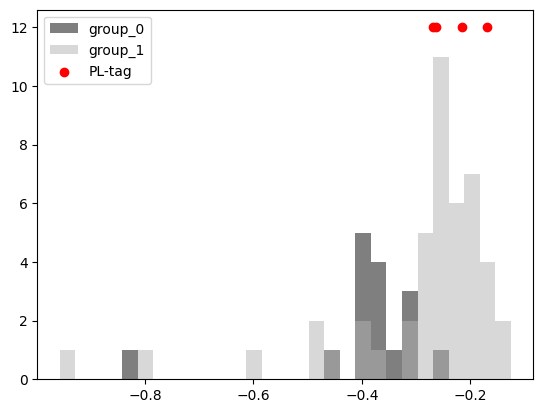

In [138]:
bins = np.linspace(np.min(ahp), np.max(ahp), 30)
for group_ind in range(group_num):
    plt.hist(ahp[labels==group_ind], bins = bins, alp ha=0.5, label=f'group_{group_ind}', color=colors[group_ind])

plt.scatter(ahp[tag_mask], 12 * np.ones_like(ahp[tag_mask]), color='red', label = 'PL-tag')
plt.legend()
plt.savefig(os.path.join(save_path, f"ahp_hist.pdf"), format='pdf')
plt.title('AHP histogram')